# Forward-Backward Sweep Method

## Overview

The **Forward-Backward Sweep** method is an iterative numerical technique for solving optimal control problems. It alternates between:

1. **Forward sweep**: Solve the state equation forward in time
2. **Backward sweep**: Solve the adjoint (costate) equation backward in time
3. **Update**: Compute the optimal control using the optimality condition

## Problem Formulation

We consider an optimal control problem of the form:

$$\min_u J = \int_0^T L(x, u, t) \, dt$$

Subject to:
- State equation: $\dot{x} = f(x, u, t)$
- Initial condition: $x(0) = x_0$
- Boundary condition on adjoint: $\lambda(T) = 0$

The Hamiltonian is:
$$H = L(x, u, t) + \lambda \cdot f(x, u, t)$$

And the optimality conditions give us:
- Adjoint equation: $\dot{\lambda} = -\frac{\partial H}{\partial x}$
- Optimal control: $\frac{\partial H}{\partial u} = 0$

## Example Problem

We solve the following optimal control problem:

$$\min_u J = \int_0^1 \left( 5x + \frac{5}{2}u^2 \right) dt$$

Subject to:
- $\dot{x} = -\frac{1}{2}x^2 + 5u$
- $x(0) = 1$

The Hamiltonian is:
$$H = 5x + \frac{5}{2}u^2 + \lambda(-\frac{1}{2}x^2 + 5u)$$

From the optimality condition $\frac{\partial H}{\partial u} = 0$:
$$5u + 5\lambda = 0 \implies u^* = -\lambda$$

The adjoint equation is:
$$\dot{\lambda} = -\frac{\partial H}{\partial x} = -5 + x\lambda$$

## Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Parameters and Problem Definition

In [2]:
# Number of discretization points
N = 20

# Time horizon
T = 1.0

# Convergence tolerance
tolerance = 1e-5

In [3]:
# State equation: dx/dt = f(t, x, u)
def f(t, x, u):
    return -0.5 * x**2 + 5 * u

# Adjoint equation: d(lambda)/dt = g(t, lambda, x, u)
def g(t, lmbda, x, u):
    return -5 + x * lmbda

# Optimal control from the optimality condition
def optimal_control(lmbda):
    return lmbda / 2  # u* = 5*lambda / (2*5) = lambda/2

# Initial and terminal conditions
x_0 = 1.0       # Initial state
lmbda_T = 0.0   # Terminal adjoint condition

### Initialization

In [4]:
# Time grid
t = np.linspace(0, T, num=N)
dt = t[1] - t[0]

# Initialize state, control, and adjoint
x = np.zeros_like(t)
u = np.zeros_like(t)
lmbda = np.zeros_like(t)

# Apply boundary conditions
x[0] = x_0
lmbda[-1] = lmbda_T

### Forward-Backward Sweep Algorithm

The algorithm iterates until convergence:
1. **Forward sweep**: Integrate state equation from $t=0$ to $t=T$ using RK4
2. **Backward sweep**: Integrate adjoint equation from $t=T$ to $t=0$ using RK4
3. **Update control**: Apply the optimality condition
4. **Check convergence**: Compare new control with previous iteration

In [5]:
max_iterations = 1000
iteration = 0

while iteration < max_iterations:
    iteration += 1
    u_old = u.copy()
    
    # ========== FORWARD SWEEP ==========
    # Solve state equation using 4th-order Runge-Kutta
    x[0] = x_0
    for i in range(N - 1):
        u_mid = 0.5 * (u[i] + u[i + 1])  # Interpolated control at midpoint
        
        k1 = f(t[i], x[i], u[i])
        k2 = f(t[i] + dt/2, x[i] + dt*k1/2, u_mid)
        k3 = f(t[i] + dt/2, x[i] + dt*k2/2, u_mid)
        k4 = f(t[i] + dt, x[i] + dt*k3, u[i + 1])
        
        x[i + 1] = x[i] + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
    
    # ========== BACKWARD SWEEP ==========
    # Solve adjoint equation using 4th-order Runge-Kutta (backward)
    lmbda[-1] = lmbda_T
    for i in range(N - 1):
        j = N - 1 - i  # Reverse index
        
        x_mid = 0.5 * (x[j] + x[j - 1])      # Interpolated state at midpoint
        u_mid = 0.5 * (u[j] + u[j - 1])      # Interpolated control at midpoint
        
        k1 = g(t[j], lmbda[j], x[j], u[j])
        k2 = g(t[j] - dt/2, lmbda[j] - dt*k1/2, x_mid, u_mid)
        k3 = g(t[j] - dt/2, lmbda[j] - dt*k2/2, x_mid, u_mid)
        k4 = g(t[j] - dt, lmbda[j] - dt*k3, x[j - 1], u[j - 1])
        
        lmbda[j - 1] = lmbda[j] - (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
    
    # ========== UPDATE CONTROL ==========
    u = optimal_control(lmbda)
    
    # ========== CHECK CONVERGENCE ==========
    residual = np.sum(np.abs(u_old - u))
    if residual < tolerance:
        print(f"Converged in {iteration} iterations")
        print(f"Final residual: {residual:.2e}")
        break

if iteration == max_iterations:
    print(f"Warning: Did not converge after {max_iterations} iterations")

Converged in 14 iterations
Final residual: 4.58e-06


## Results Visualization

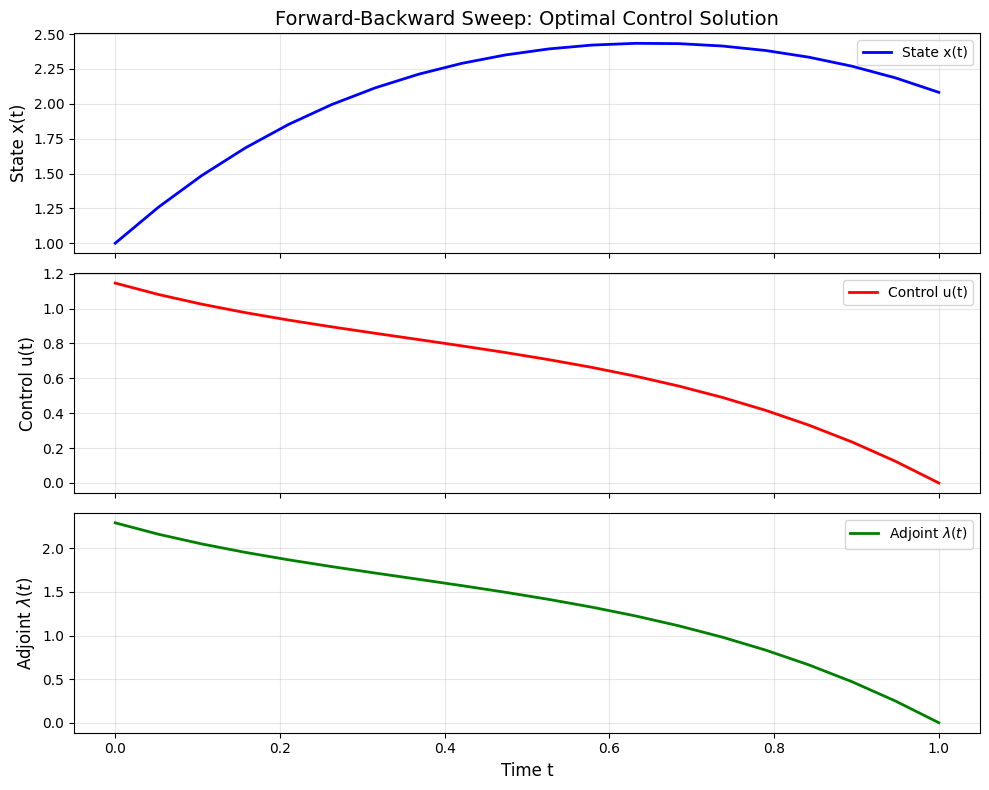

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# State trajectory
axes[0].plot(t, x, 'b-', linewidth=2, label='State x(t)')
axes[0].set_ylabel('State x(t)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Forward-Backward Sweep: Optimal Control Solution', fontsize=14)

# Optimal control
axes[1].plot(t, u, 'r-', linewidth=2, label='Control u(t)')
axes[1].set_ylabel('Control u(t)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Adjoint (costate)
axes[2].plot(t, lmbda, 'g-', linewidth=2, label=r'Adjoint $\lambda(t)$')
axes[2].set_xlabel('Time t', fontsize=12)
axes[2].set_ylabel(r'Adjoint $\lambda(t)$', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

The Forward-Backward Sweep method successfully finds the optimal control that minimizes the cost functional. Key observations:

1. **State trajectory**: The state evolves according to the dynamics under optimal control
2. **Optimal control**: Computed from the optimality condition $u^* = \lambda/2$
3. **Adjoint variable**: Captures the sensitivity of the cost with respect to state perturbations

### Algorithm Properties
- **Convergence**: Usually fast for well-posed problems
- **Accuracy**: Order depends on the integration scheme (RK4 here gives 4th order)
- **Stability**: May require under-relaxation for some problems